# calculate vix

1. hugo https://www.joinquant.com/view/community/detail/787f5bf7ba5add2d5bc68e154046c10e?type=1

In [42]:
import pickle
import json

import talib
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import timedelta
from scipy.interpolate import interp1d

from jqdata import *
from jqdata import macro

In [137]:
symbol='510050.XSHG'
start_date='2023-01-04'
end_date='2023-11-27'

In [143]:
class CH_VIX(object):
    
    def __init__(self,symbol,start_date,end_date,read=False):
        
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        
        self.read = read
        self.OptData = pd.DataFrame()
        
        
    def GetCBOE_VIX(self) -> pd.Series:
        
        if self.read:
            
            self.OptData = pd.read_csv('./data/OptData.csv').drop(columns='Unnamed: 0')
            self.OptData['date']=pd.to_datetime(self.OptData['date'],format='%Y-%m-%d')

        
        else:
            
            self.PrepareData()
        
        
        start_dt = min(self.OptData['date'])
        end_dt = max(self.OptData['date'])
        
        df_rate = self.GetShiBor(start_dt, end_dt)

        date_index = [] # 储存index
        vix_value = []  # 储存vix
        skew_value = [] # 储存skew

        for trade_date, slice_df in tqdm(self.OptData.groupby('date'), desc='计算中..',leave=True):

            maturity, df_jy, df_cjy = self.filter_contract(slice_df)
            
            # 获取无风险收益
            self.df_rate=df_rate
            self.trade_date=trade_date
            self.jy=maturity['jy']
            self.cjy=maturity['cjy']
            
            rf_rate_jy = df_rate.loc[str(trade_date), int(maturity['jy'] * 365)]             
            rf_rate_cjy = df_rate.loc[str(trade_date), int(maturity['cjy'] * 365)]

            # 计算远期价格
            fp_jy = self.cal_forward_price(maturity['jy'], rf_rate=rf_rate_jy, df=df_jy)
            fp_cjy = self.cal_forward_price(maturity['cjy'], rf_rate=rf_rate_cjy, df=df_cjy)

            # 计算中间价格
            df_mp_jy = self.cal_mid_price(maturity['jy'], df_jy, fp_jy)
            df_mp_cjy = self.cal_mid_price(maturity['cjy'], df_cjy, fp_cjy)

            # 计算行权价差
            df_diff_k_jy = self.cal_k_diff(df_jy)
            df_diff_k_cjy = self.cal_k_diff(df_cjy)

            # 计算VIX
            df_tovix_jy = pd.concat([df_mp_jy, df_diff_k_jy], axis=1).reset_index()
            df_tovix_cjy = pd.concat([df_mp_cjy, df_diff_k_cjy],
                                     axis=1).reset_index()

            nearest_k_jy = self._nearest_k(df_jy, fp_jy)
            nearest_k_cjy = self._nearest_k(df_cjy, fp_cjy)


            vix = self.cal_vix(df_tovix_jy, fp_jy, rf_rate_jy, maturity['jy'],
                          nearest_k_jy, df_tovix_cjy, fp_cjy, rf_rate_cjy,
                          maturity['cjy'], nearest_k_cjy)

            skew = self.cal_skew(df_tovix_jy, fp_jy, rf_rate_jy, maturity['jy'],
                            nearest_k_jy, df_tovix_cjy, fp_cjy, rf_rate_cjy,
                            maturity['cjy'], nearest_k_cjy)

            date_index.append(trade_date)
            vix_value.append(vix)
            skew_value.append(skew)

        data = pd.DataFrame({
            "CH_VIX": vix_value,
            "CH_SKEW": skew_value
        },
                            index=date_index)
        
        data.fillna(method='pad', inplace=True)
        
        data.index = pd.DatetimeIndex(data.index)
        

        return data

    # 获取期权信息
    def GetOptContractBasicInfo(self) -> pd.DataFrame:

        # CO-认购期权，PO-认沽期权
        OptionContractBasicInfo = opt.run_query(
            query(opt.OPT_CONTRACT_INFO.list_date,
                  opt.OPT_CONTRACT_INFO.exercise_date,
                  opt.OPT_CONTRACT_INFO.exercise_price,
                  opt.OPT_CONTRACT_INFO.contract_type,
                  opt.OPT_CONTRACT_INFO.code).filter(
                      opt.OPT_CONTRACT_INFO.underlying_symbol == self.symbol,
                opt.OPT_CONTRACT_INFO.last_trade_date >= self.start_date,
            opt.OPT_CONTRACT_INFO.list_date <= self.end_date))

        return OptionContractBasicInfo


    # 获取期权日线行情
    @staticmethod
    def GetOptDailyPrice(code_list:list) -> pd.DataFrame:
        
        price_temp = []  # 储存数据

        # 获取某合约代码日数据
        for CODE in tqdm(code_list, desc='DownLoad Daily Price',leave=True):

            q = query(
                opt.OPT_DAILY_PRICE.date, opt.OPT_DAILY_PRICE.close,
                opt.OPT_DAILY_PRICE.code).filter(opt.OPT_DAILY_PRICE.code == CODE)

            price_temp.append(opt.run_query(q))
        
        return pd.concat(price_temp)


    # 数据准备
    def PrepareData(self):
        
        start = self.start_date
        end = self.end_date
        
        # 获取期权基本信息
        OptContractBasicInfo = self.GetOptContractBasicInfo()
        # 获取期权合约代码
        code_list = OptContractBasicInfo['code'].unique().tolist()
        # 获取日线行情
        OptDailyPrice = self.GetOptDailyPrice(code_list)
        
        # 查询计算期里的日线
        date_ = pd.to_datetime(OptDailyPrice['date'])
        OptDailyPrice = OptDailyPrice[(date_>=start)&(date_<=end)]
        
        OptData = pd.merge(OptDailyPrice, OptContractBasicInfo, on='code')

        # 计算到行权日距离
        ## T的计算
        OptData['maturity'] = (pd.to_datetime(OptData['exercise_date']) -
                               pd.to_datetime(OptData['date'])) / timedelta(365)

        use_col = 'date,close,contract_type,exercise_price,maturity'.split(',')

        df_use = OptData[use_col].copy()

        df_use['contract_type'] = df_use['contract_type'].map({
            "CO": "call",
            "PO": "put"
        })
        df_use = df_use.sort_values('date')

        print('数据已储存 ./data/OptData.csv')
        df_use.to_csv('./data/OptData.csv')
        
        self.OptData = df_use

    # 通过ts获取SHIBOR数据
    @staticmethod
    def GetShiBor(startDate: str, endDate: str) -> pd.DataFrame:
        '''
        startDate,endDate 格式需要为yyyy-mm-dd
        '''
       
        # 单次最大2000行

        limit = 2000
        dates = [x.strftime('%Y%m%d') for x in get_trade_days(startDate, endDate)]
        n_days = len(dates)

        if n_days > limit:

            n = n_days // limit
            df_list = []
            i = 0
            pos1, pos2 = n * i, n * (i + 1) - 1

            while pos2 < n_days:
                # 根据@艾布拉姆斯的提示 修复此部分
                q = query(macro.MAC_LEND_RATE).filter(
                    (macro.MAC_LEND_RATE.market_id==5)&(macro.MAC_LEND_RATE.currency_id==1)&(macro.MAC_LEND_RATE.day>=startDate)&(macro.MAC_LEND_RATE.day<=endDate))
                df = macro.run_query(q)
                # 一周=7，两周=14，三周=9，一月=1，两月=2，三月=3，四月=4,五月=5，六月=6，七月=21，八月=22，九月=23,十月=24，十一月=25，一年=12。注意不是每个拆借市场都支持所有的拆解周期
                jq_tushare_col_mapper={'day':'date',20:'on',7:'1w'      ,14:'2w'      ,1:'1m'      ,3:'3m'      ,6:'6m'      ,23:'9m'      ,12:'1y'}
                df=df.pivot_table(values='interest_rate',index='day',columns='term_id').reset_index().rename(columns=jq_tushare_col_mapper).set_index('date')
                df=shibor_df.loc[:,list(jq_tushare_col_mapper.values())].set_index('date')
# hugo
#                 df = pro.shibor(
#                     start_date=dates[pos1], end_date=dates[pos2]).set_index('date')

                # return structure
#                      date      on      1w      2w      1m      3m      6m      9m      1y
#                 0    20181101  2.5470  2.6730  2.6910  2.6960  2.9760  3.2970  3.5040  3.5500
#                 1    20181031  2.3700  2.7150  2.7300  2.6890  2.9630  3.2980  3.5040  3.5500
#                 2    20181030  1.5660  2.5980  2.6400  2.6630  2.9570  3.2950  3.5010  3.5500

                df_list.append(shibor_df)
                i += 1
                pos1, pos2 = n * i, n * (i + 1) - 1

            if pos1 < n_days:

                df = pro.shibor(
                    start_date=dates[pos1], end_date=dates[-1]).set_index('date')

                df_list.append(df)

            shibor_df = pd.concat(df_list, axis=0)

        else:
            q = query(macro.MAC_LEND_RATE).filter(
                (macro.MAC_LEND_RATE.market_id==5)&(macro.MAC_LEND_RATE.currency_id==1)&(macro.MAC_LEND_RATE.day>=startDate)&(macro.MAC_LEND_RATE.day<=endDate))
            df = macro.run_query(q)
            # 一周=7，两周=14，三周=9，一月=1，两月=2，三月=3，四月=4,五月=5，六月=6，七月=21，八月=22，九月=23,十月=24，十一月=25，一年=12。注意不是每个拆借市场都支持所有的拆解周期
            jq_tushare_col_mapper={'day':'date',20:'on',7:'1w'      ,14:'2w'      ,1:'1m'      ,3:'3m'      ,6:'6m'      ,23:'9m'      ,12:'1y'}
            shibor_df=df.pivot_table(values='interest_rate',index='day',columns='term_id').reset_index().rename(columns=jq_tushare_col_mapper)
            shibor_df=shibor_df.loc[:,list(jq_tushare_col_mapper.values())].set_index('date')
            # hugo
#             shibor_df = pro.shibor(
#                 start_date=startDate.strftime('%Y%m%d'),
#                 end_date=endDate.strftime('%Y%m%d')).set_index('date')

        shibor_df.index = pd.DatetimeIndex(shibor_df.index)
        shibor_df.sort_index(inplace=True)
        
        # 差值
        def _interpld_fun(r):

            y_vals = r.values / 100

            daily_range = np.arange(1, 361)
            periods = [1, 7, 14, 30, 90, 180, 270, 360]

            # 插值
            f = interp1d(periods, y_vals, kind='cubic')
            t_ser = pd.Series(data=f(daily_range), index=daily_range)

            return t_ser

        shibor_df = shibor_df.apply(lambda x: _interpld_fun(x), axis=1)

        shibor_df.index = pd.DatetimeIndex(shibor_df.index)

        return shibor_df


    # 选出当日的近远月合约(且到期日大于1周)
    def filter_contract(self,cur_df: pd.DataFrame):

        # 今天在交易的合约的到期日
        ex_t = cur_df['maturity'].unique()
        # 选择到期日大于等于5天的数据
        ex_t = ex_t[ex_t >= 5. / 365]
        
        # 到期日排序，最小两个为近月、次近月
        try:
            jy_dt, cjy_dt = np.sort(ex_t)[:2]
        
        except ValueError:
            
            print(ex_t,np.sort(ex_t)[:2])
        
        maturity_dict = dict(zip(['jy', 'cjy'], [jy_dt, cjy_dt]))

        # 选取近月及次近月合约
        cur_df = cur_df[cur_df['maturity'].isin([jy_dt, cjy_dt])]

        keep_cols = ['close', 'contract_type', 'exercise_price']

        cur_df_jy = cur_df.query('maturity==@jy_dt')[keep_cols]
        cur_df_cjy = cur_df.query('maturity==@cjy_dt')[keep_cols]

        cur_df_jy = cur_df_jy.pivot_table(
            index='exercise_price', columns='contract_type', values='close')

        cur_df_cjy = cur_df_cjy.pivot_table(
            index='exercise_price', columns='contract_type', values='close')

        # TODO:df 中可能存在缺少call,put的情况需要加过滤check一下

        # 检查字段
        cur_df_jy = self._check_fields(cur_df_jy)
        cur_df_cjy = self._check_fields(cur_df_cjy)
        
        # 绝对值差异
        cur_df_jy['diff'] = np.abs(cur_df_jy['call'] - cur_df_jy['put'])
        cur_df_cjy['diff'] = np.abs(cur_df_cjy['call'] - cur_df_cjy['put'])

        return maturity_dict, cur_df_jy, cur_df_cjy


    # 字段检查
    @staticmethod
    def _check_fields(x_df: pd.DataFrame) -> pd.DataFrame:

        # 目标字段
        target_fields = ['call', 'put']

        for col in target_fields:

            if col not in x_df.columns:
                print("%s字段为空" % col)
                df[col] = 0

        return x_df


    # 计算远期价格
    @staticmethod
    def cal_forward_price(maturity: dict, rf_rate: float,
                          df: pd.DataFrame) -> float:

        # 获取认购与认沽的绝对值差异最小值的信息
        min_con = df.sort_values('diff').iloc[0]

        # 获取的最小exercise_price
        k_min = min_con.name

        # F = Strike Price + e^RT x (Call Price - Put Price)
        f_price = k_min + np.exp(maturity * rf_rate) * (
            min_con['call'] - min_con['put'])

        return f_price


    # 计算中间价格
    def cal_mid_price(self,maturity: dict, df: pd.DataFrame,
                      forward_price: float) -> pd.DataFrame:

        def _cal_mid_fun(x, val: float):
            res = None
            if x['exercise_price'] < val:
                res = x['put']
            elif x['exercise_price'] > val:
                res = x['call']
            else:
                res = (x['put'] + x['call']) / 2
            return res

        # 小于远期价格且最靠近的合约的行权价
        m_k = self._nearest_k(df, forward_price)

        ret = pd.DataFrame(index=df.index)

        # 计算中间件
        m_p_lst = df.reset_index().apply(lambda x: _cal_mid_fun(x, val=m_k), axis=1)

        ret['mid_p'] = m_p_lst.values

        return ret


    # 寻找最近合约
    @staticmethod
    def _nearest_k(df: pd.DataFrame, forward_price: float) -> float:

        # 行权价等于或小于远期价格的合约
        temp_df = df[df.index <= forward_price]
        if temp_df.empty:

            temp_df = df

        m_k = temp_df.sort_values('diff').index[0]

        return m_k


    # 计算行权价间隔
    @staticmethod
    def cal_k_diff(df: pd.DataFrame) -> pd.DataFrame:

        arr_k = df.index.values
        ret = pd.DataFrame(index=df.index)

        res = []
        res.append(arr_k[1] - arr_k[0])
        res.extend(0.5 * (arr_k[2:] - arr_k[0:-2]))
        res.append(arr_k[-1] - arr_k[-2])
        ret['diff_k'] = res
        return ret


    # 计算VIX
    @staticmethod
    def cal_vix_sub(df: pd.DataFrame, forward_price: float, rf_rate: float,
                    maturity: float, nearest_k: float):

        def _vix_sub_fun(x):
            ret = x['diff_k'] * np.exp(rf_rate * maturity) * x['mid_p'] / np.square(
                x['exercise_price'])
            return ret

        temp_var = df.apply(lambda x: _vix_sub_fun(x), axis=1)

        sigma = 2 * temp_var.sum() / maturity - np.square(forward_price /
                                                          nearest_k - 1) / maturity

        return sigma


    # 计算近、次近月VIX
    def cal_vix(self,df_jy: pd.DataFrame, forward_price_jy: float, rf_rate_jy: float,
                maturity_jy: float, nearest_k_jy: float, df_cjy: pd.DataFrame,
                forward_price_cjy: float, rf_rate_cjy: float, maturity_cjy: float,
                nearest_k_cjy: float):

        sigma_jy = self.cal_vix_sub(df_jy, forward_price_jy, rf_rate_jy, maturity_jy,
                               nearest_k_jy)

        sigma_cjy = self.cal_vix_sub(df_cjy, forward_price_cjy, rf_rate_cjy,
                                maturity_cjy, nearest_k_cjy)

        w = (maturity_cjy - 30.0 / 365) / (maturity_cjy - maturity_jy)

        to_sqrt = maturity_jy * sigma_jy * w + maturity_cjy * sigma_cjy * (1 - w)

        if to_sqrt >= 0:

            vix = 100 * np.sqrt(to_sqrt * 365.0 / 30)

        else:

            vix = np.nan

        return vix


    # 计算SKEW
    def cal_skew(self,df_jy:pd.DataFrame, forward_price_jy:float, rf_rate_jy:float, maturity_jy:float, nearest_k_jy:float,
                 df_cjy:pd.DataFrame, forward_price_cjy:float, rf_rate_cjy:float, maturity_cjy:float,
                 nearest_k_cjy:float)->float:

        s_jy = self.cal_moments_sub(df_jy, maturity_jy, rf_rate_jy, forward_price_jy,
                               nearest_k_jy)

        s_cjy = self.cal_moments_sub(df_cjy, maturity_cjy, rf_rate_cjy,
                                forward_price_cjy, nearest_k_cjy)

        w = (maturity_cjy - 30.0 / 365) / (maturity_cjy - maturity_jy)

        skew = 100 - 10 * (w * s_jy + (1 - w) * s_cjy)

        return skew

    @staticmethod
    def cal_epsilon(forward_price:float, nearest_k:float)->tuple:

        e1 = -(1 + np.log(forward_price / nearest_k) - forward_price / nearest_k)

        e2 = 2 * np.log(nearest_k / forward_price) * (
            nearest_k / forward_price - 1) + np.square(
                np.log(nearest_k / forward_price)) * 0.5

        e3 = 3 * np.square(np.log(nearest_k / forward_price)) * (
            np.log(nearest_k / forward_price) / 3 - 1 + forward_price / nearest_k)

        return e1, e2, e3


    def cal_moments_sub(self,df:pd.DataFrame, maturity:float, rf_rate:float, forward_price:float, nearest_k:float)->float:

        e1, e2, e3 = self.cal_epsilon(forward_price, nearest_k)

        temp_p1 = -np.sum(
            df['mid_p'] * df['diff_k'] / np.square(df['exercise_price']))

        p1 = np.exp(maturity * rf_rate) * (temp_p1) + e1

        temp_p2 = np.sum(df['mid_p'] * df['diff_k'] * 2 *
                         (1 - np.log(df['exercise_price'] / forward_price)) /
                         np.square(df['exercise_price']))
        p2 = np.exp(maturity * rf_rate) * (temp_p2) + e2

        temp_p3 = temp_p3 = np.sum(
            df['mid_p'] * df['diff_k'] * 3 *
            (2 * np.log(df['exercise_price'] / forward_price) -
             np.square(np.log(df['exercise_price'] / forward_price))) /
            np.square(df['exercise_price']))

        p3 = np.exp(maturity * rf_rate) * (temp_p3) + e3

        s = (p3 - 3 * p1 * p2 + 2 * p1**3) / (p2 - p1**2)**(3 / 2)

        return s

In [145]:
# 获取CBOE的VIX SKEW
# VIX = CH_VIX(symbol,start_date,end_date,True)
VIX = CH_VIX(symbol,start_date,end_date,False)
VIX_ser = VIX.GetCBOE_VIX()

DownLoad Daily Price: 100%|██████████| 560/560 [00:13<00:00, 42.60it/s]


数据已储存 ./data/OptData.csv


计算中..: 100%|██████████| 217/217 [00:11<00:00, 18.59it/s]


In [149]:
VIX_ser.to_csv('./res/VIX_res.csv')

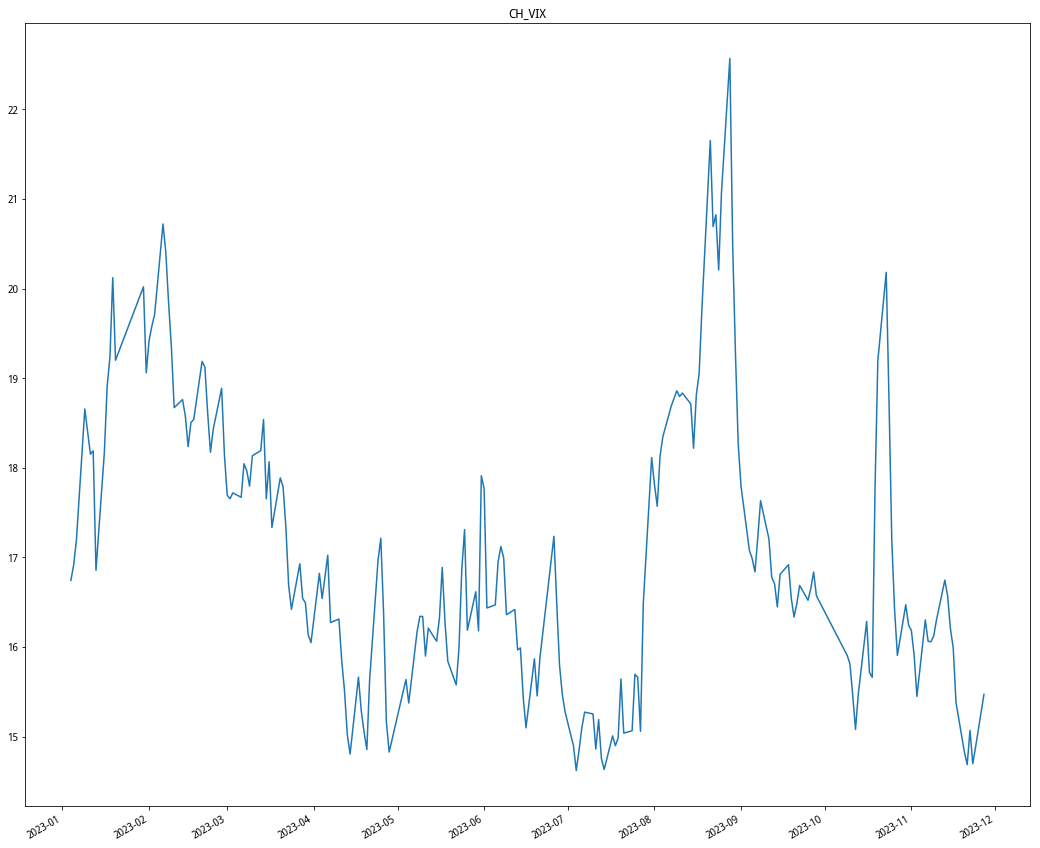

In [154]:
VIX_ser['CH_VIX'].plot(figsize=(18, 16), title='CH_VIX').get_figure().savefig(f'./res/CH_VIX_{start_date}_{end_date}.png',dpi=320,bbox_inches='tight')
